# K-fold Cross Validation for XLNet model using TensorFlow

### Import the neccesary libraries

In [1]:
import transformers
from transformers import XLNetTokenizer
from transformers import TFXLNetForSequenceClassification
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Dataset 

In [2]:
df = pd.read_csv('randomized_balanced.csv')
df.head()

,review,label
0,Seems more transparent & meaningful issues.,rating
1,The best app for editing texts,rating
2,It seems like it would be a great addition to ...,feature request
3,Its really fun and any age can play it and enj...,user experience
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report


## Start of Preprocessing

In [3]:
df['count'] = df['review'].apply(lambda x: len(x.split())) # add a column for the number of words in the review
df.head()

,review,label,count
0,Seems more transparent & meaningful issues.,rating,6
1,The best app for editing texts,rating,6
2,It seems like it would be a great addition to ...,feature request,27
3,Its really fun and any age can play it and enj...,user experience,20
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43


### Get the number of word distrubution in the dataset

<Figure size 800x800 with 0 Axes>

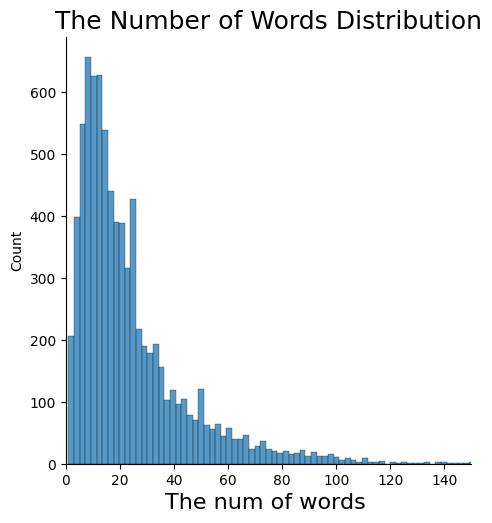

In [4]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 150)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

### Assign a Unique Integer for each target Class

In [5]:
df['encoded_text'] = df['label'].astype('category').cat.codes # encode the class labels

df.head(10)

,review,label,count,encoded_text
0,Seems more transparent & meaningful issues.,rating,6,2
1,The best app for editing texts,rating,6,2
2,It seems like it would be a great addition to ...,feature request,27,1
3,Its really fun and any age can play it and enj...,user experience,20,3
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43,0
5,Good app really really Best app Thanks Faceboo...,rating,9,2
6,I think we should get more.,feature request,6,1
7,No option for dark mode on my Motorola g5 stylus,feature request,10,1
8,atomic_number_53 gave it a 4 star because I co...,bug report,19,0
9,"Not what it use to be, too many ads. Not enoug...",user experience,47,3


In [6]:
# Convert the reviews and labels to numpy arrays 
data_texts = np.array(df['review'])  
data_labels = np.array(df['encoded_text'])  

### Initialize the XLNet Tokenizer

In [7]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

## K-Fold Cross Validation for XLNet Model

In [8]:
# Initialize the k-fold and the number of folds
kf = KFold(n_splits=5, shuffle=False, random_state=None)

# The main loop
for fold, (train_index, val_index) in enumerate(kf.split(data_texts), 1): # Start counting fold from 1
    print(f"Fold {fold}") # Print the fold number to keep track of the training process
    
    train_texts, val_texts = data_texts[train_index], data_texts[val_index] # Split the data into training and validation sets
    train_labels, val_labels = data_labels[train_index], data_labels[val_index]

    # Tokenization
    train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="tf") # Tokenize the training set
    val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="tf") # Tokenize the validation set

    # Convert to TensorFlow datasets 
    train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(8)
    val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(8)

    # Model initialization
    model = TFXLNetForSequenceClassification.from_pretrained('xlnet-base-cased',num_labels=len(np.unique(data_labels)))

    # Model compilation with custom parameters
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=tf.metrics.SparseCategoricalAccuracy())

    # Model training on the training set
    model.fit(train_dataset, validation_data=val_dataset, epochs=5)

    # Model evaluation on the validation set
    val_pred = np.argmax(model.predict(val_dataset).logits, axis=1)
    accuracy = accuracy_score(val_labels, val_pred)
    precision = precision_score(val_labels, val_pred, average=None)
    recall = recall_score(val_labels, val_pred, average=None)
    f1 = f1_score(val_labels, val_pred, average=None)

    # Print the evaluation metrics for each fold
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy}, - Precision: {precision}, - Recall: {recall}, - F1 Score: {f1}")



Fold 1



C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that 

Epoch 1/5

800/800 [==============================] - 1354s 2s/step - loss: 0.9118 - sparse_categorical_accuracy: 0.6175 - val_loss: 0.6436 - val_sparse_categorical_accuracy: 0.7425
Epoch 2/5
800/800 [==============================] - 1327s 2s/step - loss: 0.5554 - sparse_categorical_accuracy: 0.7952 - val_loss: 0.5178 - val_sparse_categorical_accuracy: 0.8094
Epoch 3/5
800/800 [==============================] - 1327s 2s/step - loss: 0.3571 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.4779 - val_sparse_categorical_accuracy: 0.8363
Epoch 4/5
800/800 [==============================] - 1322s 2s/step - loss: 0.2185 - sparse_categorical_accuracy: 0.9261 - val_loss: 0.3954 - val_sparse_categorical_accuracy: 0.8813
Epoch 5/5
200/200 [==============================] - 88s 433ms/step
Fold 1
Accuracy: 0.87875, - Precision: [0.91105769 0.93734336 0.95015576 0.75      ], - Recall: [0.94044665 0.87793427 0.7625     0.93800539], - F1 Score: [0.92551893 0.90666667 0.84604716 0.83353293]
Fold 2

C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that 

Epoch 1/5
800/800 [==============================] - 1358s 2s/step - loss: 0.8681 - sparse_categorical_accuracy: 0.6469 - val_loss: 0.6347 - val_sparse_categorical_accuracy: 0.7669
Epoch 2/5
800/800 [==============================] - 1329s 2s/step - loss: 0.5167 - sparse_categorical_accuracy: 0.8128 - val_loss: 0.5907 - val_sparse_categorical_accuracy: 0.7894
Epoch 3/5
800/800 [==============================] - 1326s 2s/step - loss: 0.3352 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.4826 - val_sparse_categorical_accuracy: 0.8531
Epoch 4/5
800/800 [==============================] - 1327s 2s/step - loss: 0.1857 - sparse_categorical_accuracy: 0.9378 - val_loss: 0.4282 - val_sparse_categorical_accuracy: 0.8763
Epoch 5/5
200/200 [==============================] - 89s 437ms/step
Fold 2
Accuracy: 0.891875, - Precision: [0.90519187 0.94306931 0.90250696 0.81472081], - Recall: [0.96394231 0.89018692 0.85263158 0.8537234 ], - F1 Score: [0.93364377 0.91586538 0.87686062 0.83376623]
Fold 3

C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that 

Epoch 1/5
800/800 [==============================] - 1357s 2s/step - loss: 0.8825 - sparse_categorical_accuracy: 0.6375 - val_loss: 0.5900 - val_sparse_categorical_accuracy: 0.7763
Epoch 2/5
800/800 [==============================] - 1333s 2s/step - loss: 0.5140 - sparse_categorical_accuracy: 0.8064 - val_loss: 0.4790 - val_sparse_categorical_accuracy: 0.8250
Epoch 3/5
800/800 [==============================] - 1323s 2s/step - loss: 0.3098 - sparse_categorical_accuracy: 0.8956 - val_loss: 0.4325 - val_sparse_categorical_accuracy: 0.8556
Epoch 4/5
800/800 [==============================] - 1319s 2s/step - loss: 0.1941 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.3678 - val_sparse_categorical_accuracy: 0.8925
Epoch 5/5
200/200 [==============================] - 90s 440ms/step
Fold 3
Accuracy: 0.908125, - Precision: [0.90117647 0.91129032 0.95555556 0.87358916], - Recall: [0.97208122 0.90884718 0.83698297 0.91706161], - F1 Score: [0.93528694 0.91006711 0.8923476  0.89479769]
Fold 4

C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that 

Epoch 1/5
800/800 [==============================] - 1355s 2s/step - loss: 0.8733 - sparse_categorical_accuracy: 0.6497 - val_loss: 0.6254 - val_sparse_categorical_accuracy: 0.7550
Epoch 2/5
800/800 [==============================] - 1340s 2s/step - loss: 0.5362 - sparse_categorical_accuracy: 0.8053 - val_loss: 0.5161 - val_sparse_categorical_accuracy: 0.8069
Epoch 3/5
800/800 [==============================] - 1338s 2s/step - loss: 0.3309 - sparse_categorical_accuracy: 0.8867 - val_loss: 0.3957 - val_sparse_categorical_accuracy: 0.8669
Epoch 4/5
800/800 [==============================] - 1335s 2s/step - loss: 0.1974 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.4340 - val_sparse_categorical_accuracy: 0.8731
Epoch 5/5
200/200 [==============================] - 90s 442ms/step
Fold 4
Accuracy: 0.90375, - Precision: [0.89182692 0.93224932 0.94906166 0.85294118], - Recall: [0.9321608  0.89350649 0.85714286 0.93316832], - F1 Score: [0.91154791 0.91246684 0.90076336 0.89125296]
Fold 5


C:\Users\alpya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetForSequenceClassification: ['lm_loss']
- This IS expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetForSequenceClassification from the checkpoint of a model that 

Epoch 1/5
800/800 [==============================] - 1360s 2s/step - loss: 0.8641 - sparse_categorical_accuracy: 0.6472 - val_loss: 0.6056 - val_sparse_categorical_accuracy: 0.7644
Epoch 2/5
800/800 [==============================] - 1337s 2s/step - loss: 0.5100 - sparse_categorical_accuracy: 0.8144 - val_loss: 0.4797 - val_sparse_categorical_accuracy: 0.8256
Epoch 3/5
800/800 [==============================] - 1335s 2s/step - loss: 0.3102 - sparse_categorical_accuracy: 0.8936 - val_loss: 0.4663 - val_sparse_categorical_accuracy: 0.8544
Epoch 4/5
800/800 [==============================] - 1342s 2s/step - loss: 0.1975 - sparse_categorical_accuracy: 0.9339 - val_loss: 0.4379 - val_sparse_categorical_accuracy: 0.8656
Epoch 5/5
200/200 [==============================] - 93s 455ms/step
Fold 5
Accuracy: 0.87125, - Precision: [0.87735849 0.9512987  0.92134831 0.78320312], - Recall: [0.9562982  0.75515464 0.82828283 0.93911007], - F1 Score: [0.91512915 0.84195402 0.87234043 0.85410011]
